## Objective

To import a time series data dataset and perform EDA, data cleaning and data transformations in order to demonstrate the tools I typically use.

## Dataset

MIMIC-III Waveform Database (https://physionet.org/content/mimic3wdb/1.0/)

"The MIMIC-III Waveform Database contains 67,830 record sets for approximately 30,000 ICU patients. Almost all record sets include a waveform record containing digitized signals (typically including ECG, ABP, respiration, and PPG, and frequently other signals) and a “numerics” record containing time series of periodic measurements, each presenting a quasi-continuous recording of vital signs of a single patient throughout an ICU stay (typically a few days, but many are several weeks in duration)."

A group of researchers have cleaned and time aligned several ECG, PPG and ABP signals from this dataset for the purposes of blood pressure estimation. However, they've stored the output signals in v7.3 matlab (.mat) files. These can be imported into Python using the h5py library and transformed into numpy arrays. The cleaned data is found here: https://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation#

In [1]:
import os
import h5py
import scipy
import numpy as np
import pandas as pd
import heartpy as hp
import seaborn as sns
import scipy.signal as sig
import matplotlib.pyplot as plt

# NOTE: I have not worked heavily with EEG signals, but while putting this notebook together I can across the 
# biosppy library which seems like it has a lot of good tools for EEG signal processing.

### Load Dataset

In [2]:
# path to data
dataFilePath = os.path.abspath('.\data\Part_1.mat')

# load data
f = h5py.File(dataFilePath, 'r')

In [3]:
# display file keys
list(f.keys())

['#refs#', 'Part_1']

In [4]:
# try to get data
f.get('Part_1')

<HDF5 dataset "Part_1": shape (3000, 1), type "|O">

In [5]:
# because this is a referenced dataset, we need to use a round-about way of accessing the data

# get data
data = []

ref = f['Part_1']
for r in ref[:]:
    ds = f[r[0]]
    data.append(ds[:])

In [7]:
# summary
print('number of subjects: ', len(data))
print('number of waveforms for each subject (ECG, PPG and ABP): ', data[0].shape[1])

number of subjects:  3000
number of waveforms for each subject (ECG, PPG and ABP):  3


### Plot Waveforms

data shape for first subject:  (61000, 3)


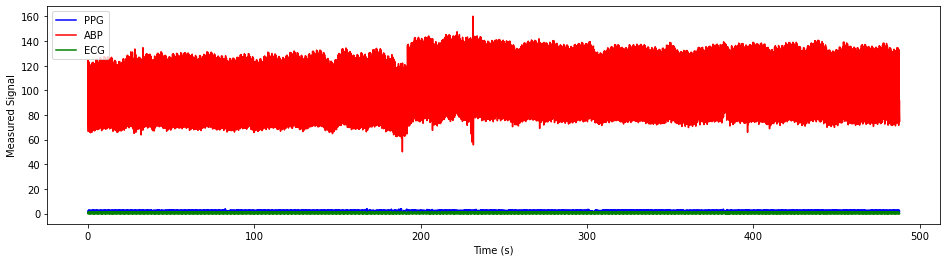

In [19]:
%matplotlib inline

# get first subject
curSubj = data[0]
print('data shape for first subject: ', curSubj.shape)

# sample rate
fs = 125

# create time vector
endpt = curSubj.shape[0]
t = np.linspace(0, endpt/fs, num=endpt)

# plot
plt.figure(figsize=(16,4))
plt.plot(t,curSubj.T[0],'blue')
plt.plot(t,curSubj.T[1],'red')
plt.plot(t,curSubj.T[2],'green');
plt.xlabel('Time (s)'); plt.ylabel('Measured Signal');
plt.legend(['PPG', 'ABP', 'ECG'])
plt.show()

The first waveform in the dataset is PPG (blue), the second waveform is ABP (red) and the third waveform is ECG (green). Zoomed in sections of each signal are presented below.

For all the analyses below, I will just work with the current subjects data so as to not waste time processing the entire dataset. If implementing this for an actual project, I would likely create a for loop to process all the data at once (and use AWS EC2 for faster compute times). 

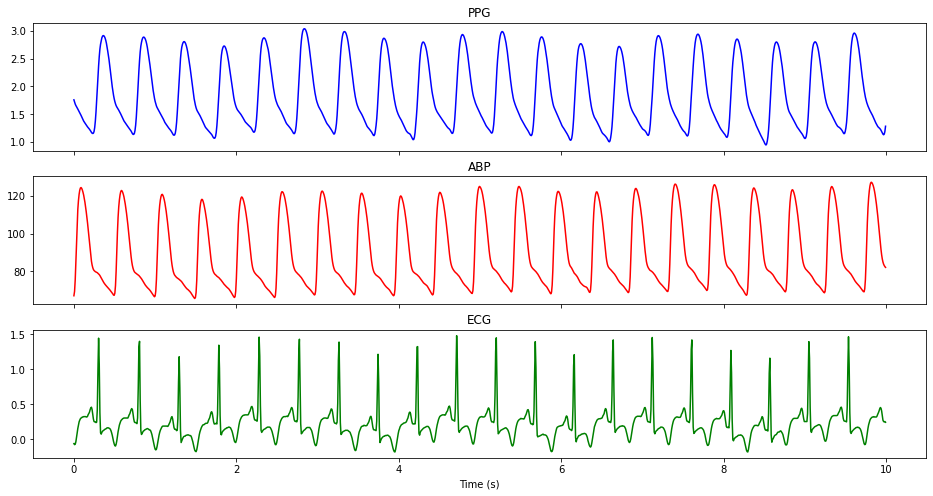

In [20]:
ppg = curSubj.T[0]
abp = curSubj.T[1]
ecg = curSubj.T[2]

# zoom in
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(16, 8))
ax0.plot(t[0:1250],ppg[0:1250],'blue'); ax0.set_title('PPG')
ax1.plot(t[0:1250],abp[0:1250],'red'); ax1.set_title('ABP')
ax2.plot(t[0:1250],ecg[0:1250],'green'); ax2.set_title('ECG');
plt.xlabel('Time (s)');
plt.show()

### PPG Analysis

The PPG signal is already pretty clean, so likely doesn't require any filtering. It also looks like the baseline wander has already been removed as well. If it hadn't been, we could have used HeartPy's 'remove_baseline_wander' function. Instead, we'll use the PPG signal as-is and find the peaks of the signal using a few different methods.

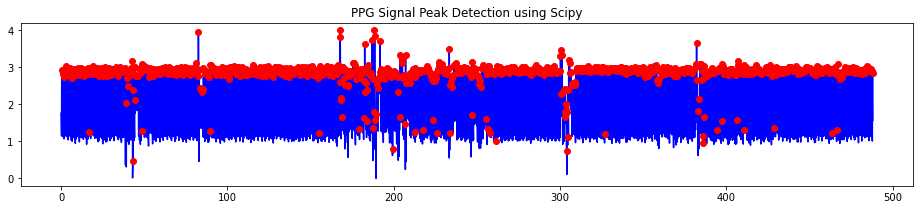

C:\Users\ta1031742\Anaconda3\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


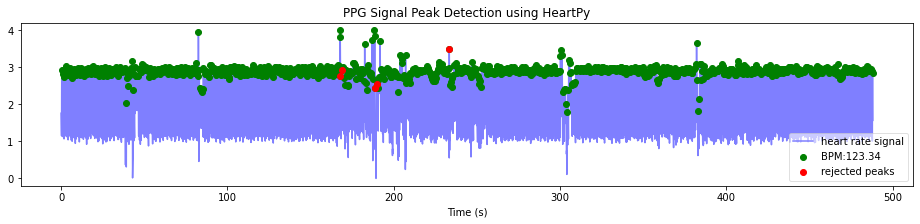

In [32]:
# find peaks of PPG using scipy 
peaks, _ = sig.find_peaks(ppg)

# plot peaks
plt.figure(figsize=(16,3))
plt.plot(t,ppg,'blue',zorder=0);
plt.scatter(t[peaks],ppg[peaks],c='red',zorder=1); 
plt.title('PPG Signal Peak Detection using Scipy');
plt.show()

# find peaks of PPG using HeartPy 
working_data, measures = hp.process(ppg, sample_rate=125)

# plot peaks
hp.plotter(working_data, measures, figsize=(16,3), title='PPG Signal Peak Detection using HeartPy')

Scipy didn't do very well detecting peaks. One way to improve this, is to utilize the optional parameters 'threshold', 'distance', 'prominence' and 'width' of the find_peaks function. However, HeartPy did the hard work for us instead. Additionally, HeartPy provides a bunch of summary metrics, as displayed below.

In [31]:
# print heartpy summary
for m in measures.keys():
    print('%s: %f' %(m, measures[m]))

bpm: 123.337304
ibi: 486.470825
sdnn: 26.175919
sdsd: 32.503521
rmssd: 35.181262
pnn20: 0.100000
pnn50: 0.032323
hr_mad: 8.000000
sd1: 24.875961
sd2: 26.033610
s: 2034.530187
sd1/sd2: 0.955533
breathingrate: 0.268845


In most cases, rather than a single BPM or HRV value, we'll want to calculate the HR or HRV over time. This is demonstrated below using sliding windows with varying amounts of overlap.

In [33]:
# get BPM and HRV over time
working_data, measures = hp.process_segmentwise(ppg, sample_rate=125) # no overlap between segments

print('segmented ppg, no overlap'); print()
print('number of segments: ', len(measures['bpm']));
print('bpm over time: ', [round(x, 1) for x in measures['bpm']]);
print('hrv over time (sdnn): ', [round(x, 1) for x in measures['sdnn']]);
print('respiration over time: ', [round(x, 1) for x in measures['breathingrate']]);print()

print('--------------------------------');print()

# process data with 50% overlap
working_data, measures = hp.process_segmentwise(ppg, sample_rate=125, segment_overlap=0.5)

print('segmented ppg, 50% overlap'); print()
print('number of segments: ', len(measures['bpm']));
print('bpm over time: ', [round(x, 1) for x in measures['bpm']]);
print('hrv over time (sdnn): ', [round(x, 1) for x in measures['sdnn']]);
print('respiration over time: ', [round(x, 1) for x in measures['breathingrate']]);print()


segmented ppg, no overlap

number of segments:  4
bpm over time:  [123.4, 124.9, 122.2, 123.0]
hrv over time (sdnn):  [24.2, 37.1, 23.1, 15.6]
respiration over time:  [0.2, 0.3, 0.2, 0.2]

--------------------------------

segmented ppg, 50% overlap

number of segments:  8
bpm over time:  [123.4, 124.2, 124.9, 123.2, 122.2, 122.8, 123.0, 122.7]
hrv over time (sdnn):  [24.2, 24.2, 37.1, 34.3, 23.1, 24.9, 15.6, 7.2]
respiration over time:  [0.2, 0.2, 0.3, 0.3, 0.2, 0.2, 0.2, 0.3]



We can also flip the PPG signal and get the troughs.

<IPython.core.display.Javascript object>


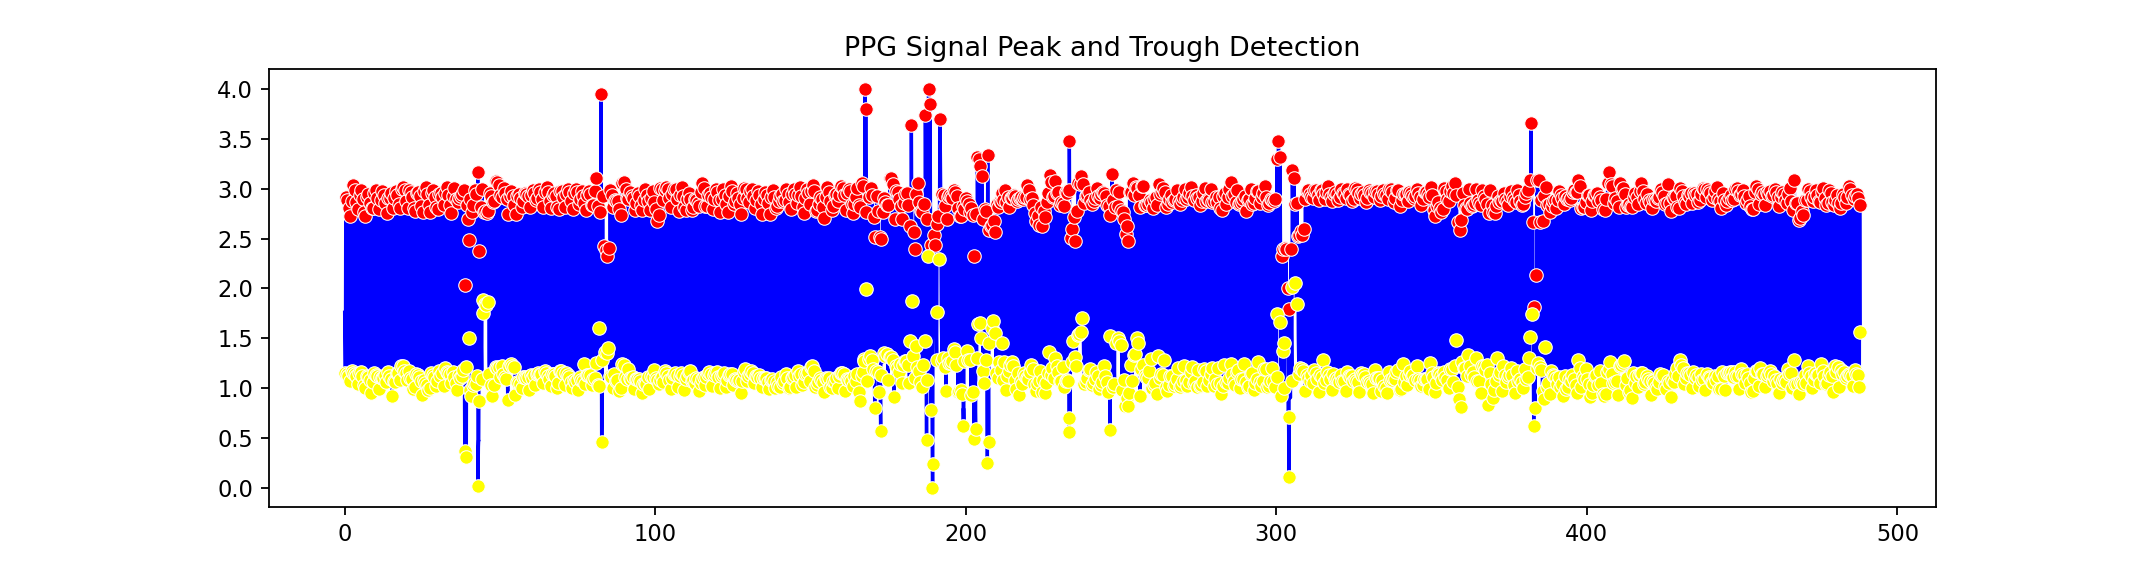

In [34]:
# get peaks
working_data, measures = hp.process(ppg, sample_rate=125)
peaks = working_data['peaklist']

# flip ppg signal
ppg_invert = hp.flip_signal(ppg)

# get troughs
working_data, measures = hp.process(ppg_invert, sample_rate=125)
troughs = working_data['peaklist']

# get time between peak and trough
t = np.linspace(0, endpt/fs, num=endpt)

# plot peaks and troughs
%matplotlib notebook
fig, ax = plt.subplots()
sns.lineplot(x=t,y=ppg, color='blue',ax=ax,zorder=0); plt.show()
sns.scatterplot(x=t[peaks],y=ppg[peaks], color='red',ax=ax,zorder=1); plt.show()
sns.scatterplot(x=t[troughs],y=ppg[troughs], color='yellow',ax=ax,zorder=2); plt.show()
ax.set(title='PPG Signal Peak and Trough Detection');

For some models, rather than using the full PPG time series at input, we may want discrete features from the signal as inputs. One such feature may be the time between the peak and trough of the signal. Some code demonstrating how to extract this feature is below.

In [35]:
# this is a quick and dirty implementation
# likely needs some revisions and additional rules
# im simply including this to demonstrate some different types of analyses that could be done

features = []

# if a peak occurs first
if peaks[0] < troughs[0]:
    
    # loop through all peaks
    for i,pk in enumerate(peaks):
        
        # break out of loop if you run out of troughs
        if len(troughs) <= i:
            break
        
        # if another peak occurs before a trough, skip
        if peaks[i+1] < troughs[i]:
            continue
        # else, calculate the time between peak and trough
        else:
            features.append(t[troughs[i]] - t[pk])

# else if a trough occurs first
elif peaks[0] > troughs[0]:
    
    # loop through all troughs
    for i,tr in enumerate(troughs):
        
        # break out of loop if you run out of peaks
        if len(peaks) <= i:
            break
        
        # if another trough occurs before a peak, skip
        if troughs[i+1] < peaks[i]:
            continue
        # else, calculate the time between peak and trough
        else:
            features.append(t[peaks[i]] - t[tr])

### ECG Analysis

The ECG signal is a bit noisier than the PPG signal, so scipy.signal.find_peaks will likely perform poorly. We'll stick with HeartPy. However, HeartPy was designed for PPG signals, so we'll need to filter and resample the ECG signal to ensure good performance.

<IPython.core.display.Javascript object>


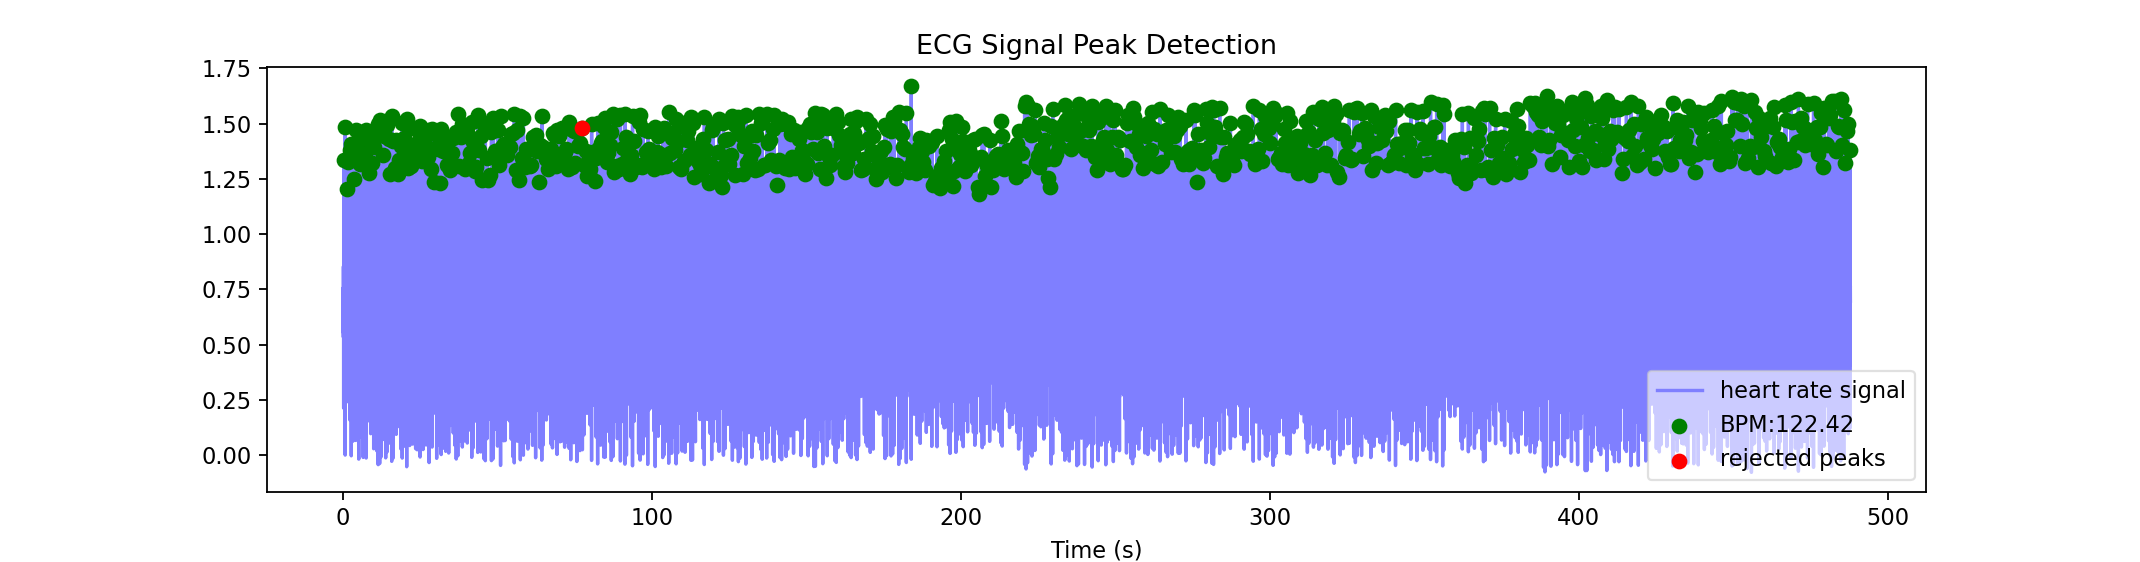

bpm: 122.424801
ibi: 490.096774
sdnn: 28.507270
sdsd: 36.981497
rmssd: 38.229645
pnn20: 0.025253
pnn50: 0.025253
hr_mad: 5.333333
sd1: 27.032438
sd2: 29.960069
s: 2544.356104
sd1/sd2: 0.902282
breathingrate: 0.205787


In [36]:
# improve snr
ecg_filt = hp.enhance_ecg_peaks(hp.scale_data(ecg), sample_rate=125, aggregation='median', iterations=5)

# resample (bc heartpy  was designed for ppg which has wider peaks compared to the narrow ecg signal)
ecg_filt = sig.resample(ecg_filt, len(ecg_filt) * 3)

# find peaks 
working_data, measures = hp.process(ecg_filt, sample_rate=125*3)

# plot peaks
%matplotlib notebook
hp.plotter(working_data, measures, title='ECG Signal Peak Detection')

# print summary
for m in measures.keys():
    print('%s: %f' %(m, measures[m]))

Filtering and resampling the ECG signal ensures the HeartPy can accurately detect the peaks. The BPM agrees very well with the PPG signal.  
  
bpm_ppg = 123  
bpm_ecg = 122

To confirm the heart rate output of HeartPy, we can plot the periodogram of the ECG to confirm that there's a dominant frequency close to ~120 BPM (2 Hz).

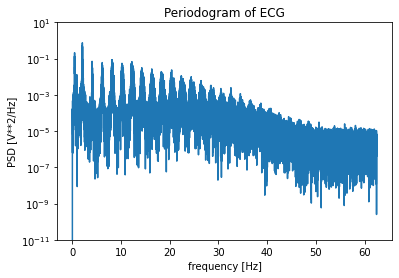

In [41]:
# ecg periodogram
f, pxx = sig.periodogram(ecg, 125)

# plot
%matplotlib inline
plt.semilogy(f, pxx)
plt.xlabel('frequency [Hz]'); plt.ylabel('PSD [V**2/Hz]')
plt.ylim([10e-12,10e0])
plt.title('Periodogram of ECG')
plt.show()

The periodogram shows periodicity occurring at lower frequencies, which is expected. A typical heart rate is between 40-180 bpm, which corresponds to 0.67-3Hz. By zooming in on that area of the periodogram we can find the dominant frequency in the signal.

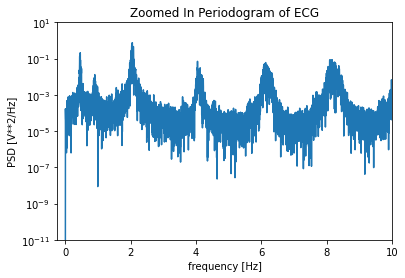

In [42]:
# plot zoomed in
plt.semilogy(f, pxx)
plt.xlabel('frequency [Hz]'); plt.ylabel('PSD [V**2/Hz]')
plt.xlim([-0.25, 10]); plt.ylim([10e-12, 10e0])
plt.title('Zoomed In Periodogram of ECG')
plt.show()

From the plot above, we can see the largest peak of the periodogram occurs at ~2.1 Hz. This corresponds to 126 BPM, which is very close to what HeartPy calculated. Additionally, HeartPy output a breathing rate of ~0.2 Hz, or 12 breathes per minute. The first peak in the periodogram above may correspond to this phenomenon.

Lowpass or bandpass filtering the ECG signal will cleanup the periodogram slighlty, as shown below. 

<IPython.core.display.Javascript object>


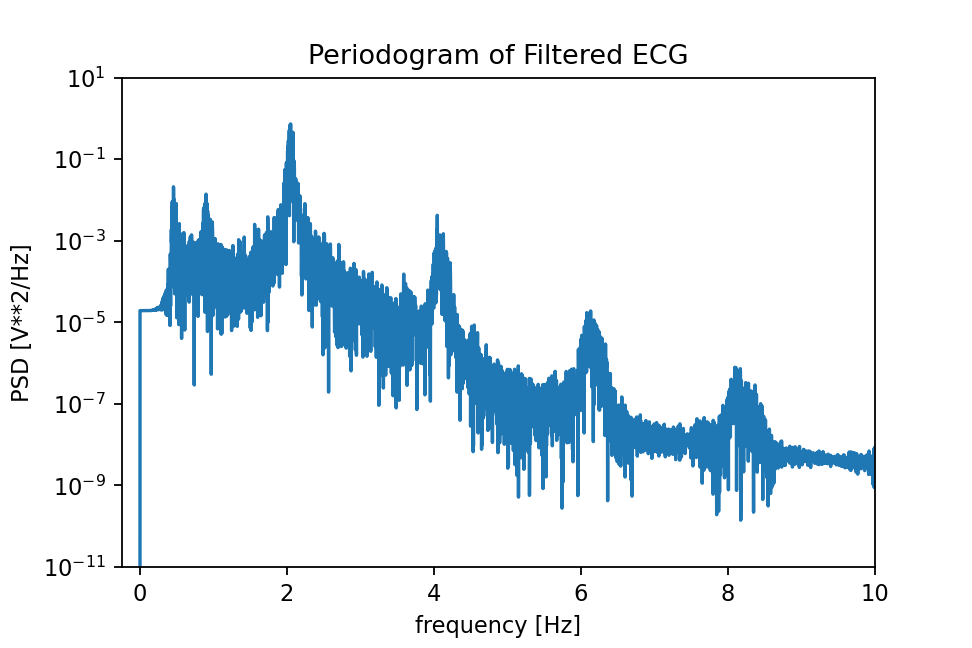

In [43]:
# bandpass butterworth filter with cutoff freq between [0.5,3.5] 
# HeartPy utilizes scipy.signal.butter to implement this filter
ecg_bp_filt = hp.filter_signal(ecg, cutoff=[0.5, 3.5], sample_rate=125, order=3, filtertype='bandpass')

# periodogram
f, pxx = sig.periodogram(ecg_bp_filt, 125)

# plot 
plt.semilogy(f, pxx)
plt.xlabel('frequency [Hz]'); plt.ylabel('PSD [V**2/Hz]')
plt.xlim([-0.25, 10]); plt.ylim([10e-12,10e0]);
plt.title('Periodogram of Filtered ECG')
plt.show()

In addition to filtering, other methods that could be utilized to clean up the signal are smoothing using as sliding window and downsampling by taking every nth data point or wavelet transformations.

### ABP Analysis

To demonstrate a few more transformations, below I will simply calculate the first and second derivatives of the ABP signal.

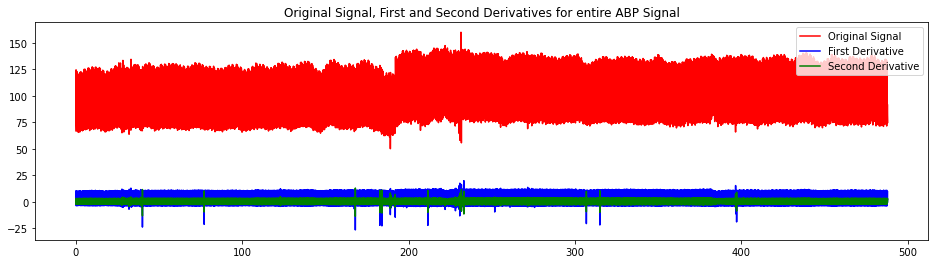

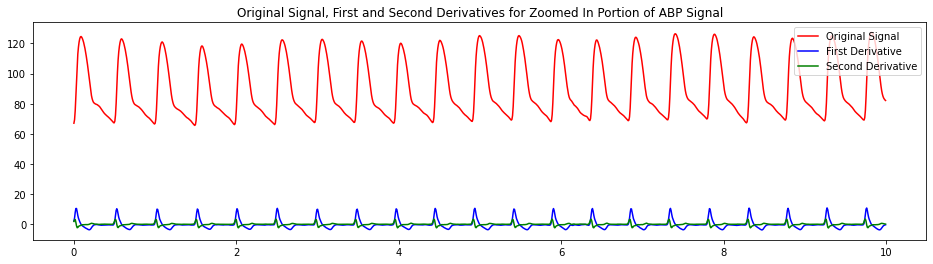

In [44]:
# first deriv
abp_first_deriv = np.gradient(abp)

# second deriv 
abp_second_deriv = np.gradient(abp_first_deriv)

# plot
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(t,abp, 'red')
plt.plot(t,abp_first_deriv, 'blue')
plt.plot(t,abp_second_deriv, 'green')
plt.title('Original Signal, First and Second Derivatives for entire ABP Signal')
plt.legend(['Original Signal', 'First Derivative', 'Second Derivative'], loc='upper right')
plt.show()

# zoom in
plt.figure(figsize=(16,4))
plt.plot(t[0:1250],abp[0:1250], 'red')
plt.plot(t[0:1250],abp_first_deriv[0:1250], 'blue')
plt.plot(t[0:1250],abp_second_deriv[0:1250], 'green')
plt.title('Original Signal, First and Second Derivatives for Zoomed In Portion of ABP Signal')
plt.legend(['Original Signal', 'First Derivative', 'Second Derivative'], loc='upper right')
plt.show()